In [144]:
import pandahouse as ph
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [126]:
ch_conn = {'host': 'http://clickhouse.beslan.pro:8080',
           'database':'default',
           'user':'student', 
           'password':'dpo_python_2020'
          }
ch_test_conn = dict(database='test',
                    host='http://clickhouse.beslan.pro:8080',
                    user='student-rw',
                    password='656e2b0c9c')
sns.set(
    font_scale=2,
    style="whitegrid",
    rc={'figure.figsize':(20,7)}
)

## Task 1

In [12]:
q = '''
    SELECT 
        COUNT(*) AS number_of_rows 
    FROM 
        ldn_listings 
    LIMIT 10
    '''

q_test = ph.read_clickhouse(query=q, connection=ch_conn)
q_test

# answer - 85207

,number_of_rows
0,85207


## Task 2

In [17]:
q = '''
    SELECT 
        room_type,
        toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) AS price
    FROM 
        ldn_listings
    ORDER BY id
    '''

q_test = ph.read_clickhouse(query=q, connection=ch_conn)
(
    q_test
    .groupby('room_type')
    .quantile([0.5,0.75])
)
    
# answer - 60.0

price
room_type                   
Entire home/apt 0.50  120.00
                0.75  180.00
Hotel room      0.50  130.00
                0.75  213.75
Private room    0.50   45.00
                0.75   60.00
Shared room     0.50   35.00
                0.75   70.00

## Task 3

<AxesSubplot: xlabel='price', ylabel='review_scores_rating'>

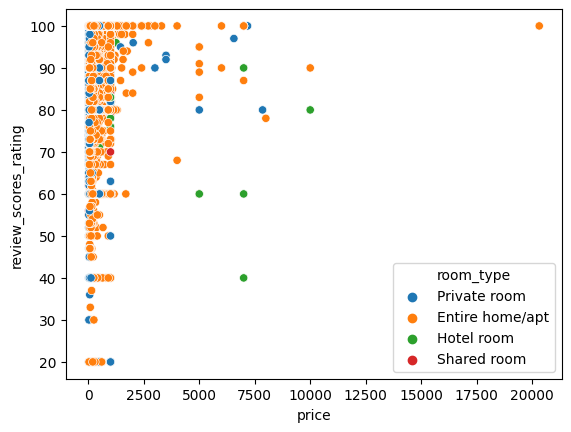

In [18]:
q = '''
    SELECT 
        room_type,
        toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) AS price,
        toFloat32OrNull(review_scores_rating) AS review_scores_rating
    FROM 
        ldn_listings
    WHERE review_scores_rating is not null
    ORDER BY id
    '''

q_test = ph.read_clickhouse(query=q, connection=ch_conn)
(
    q_test
    .groupby('room_type')
    .agg(
        avg_price = ('price', 'mean'), 
        avg_rating = ('review_scores_rating', 'mean')
    )
)
    
sns.scatterplot(q_test, x='price', y='review_scores_rating', hue='room_type')
# answer - 3 (third option)

## Task 4

In [ ]:
def get_to_list(col):
    col_list = col.replace("'","").str.strip('[]').str.split(', ')
    return col_list

In [91]:
q = '''
    SELECT 
        host_id,
        host_verifications
    FROM 
        ldn_listings
    WHERE experiences_offered != 'none'
    '''

q_test = ph.read_clickhouse(query=q, connection=ch_conn)
(
    q_test
    .assign(host_verifications = lambda x: get_to_list(x.host_verifications))
    .explode('host_verifications')
    .value_counts('host_verifications')
)
# answere - 43 (verification by google)

host_verifications
'phone'                    1548
'email'                    1531
'reviews'                  1493
'government_id'            1373
'jumio'                    1279
'offline_government_id'     573
'work_email'                322
'facebook'                  307
'selfie'                    300
'identity_manual'           272
'manual_offline'             86
'google'                     43
'kba'                        29
'manual_online'              19
'sent_id'                    13
dtype: int64

## Task 5

<AxesSubplot: xlabel='experiences_offered', ylabel='neighbourhood_cleansed'>

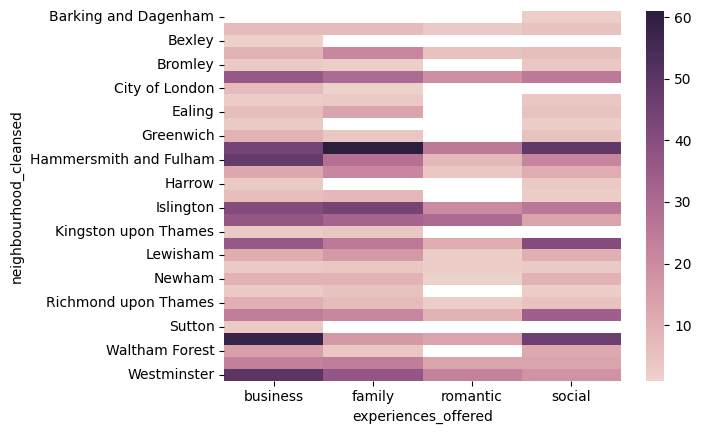

In [104]:
q = '''
    SELECT 
        neighbourhood_cleansed,
        experiences_offered,
        COUNT(*) AS experiences_count
    FROM ldn_listings
    WHERE experiences_offered != 'none'
    GROUP BY neighbourhood_cleansed, experiences_offered
    ORDER BY experiences_count DESC
    LIMIT 100
    '''

q_test = ph.read_clickhouse(query=q, connection=ch_conn)
q_pivot = (
    q_test.
    pivot(index='neighbourhood_cleansed', columns='experiences_offered', values='experiences_count')
)

cmap=sns.cubehelix_palette(as_cmap=True)
sns.heatmap(q_pivot, cmap=cmap)

# answer - 1 (first option)

## Task 6

AxesSubplot(0.125,0.11;0.775x0.77)


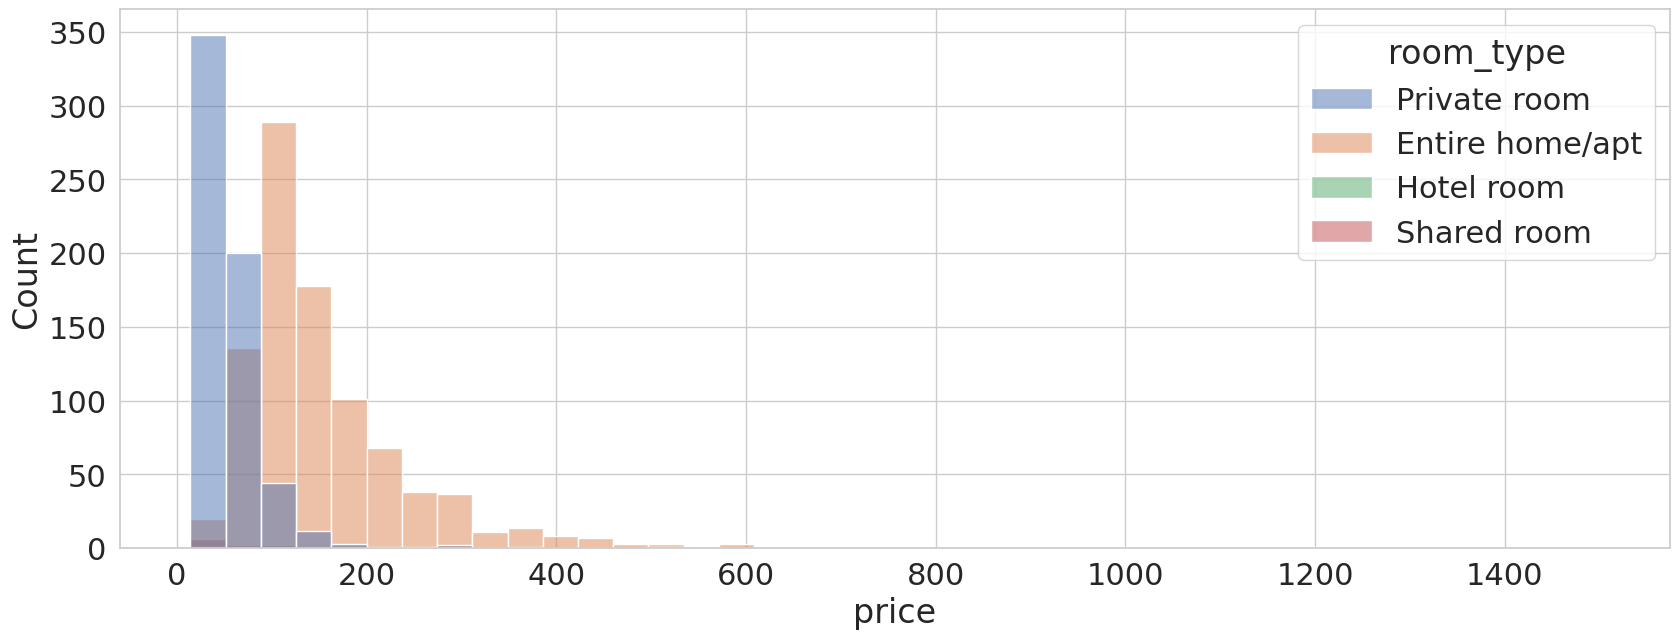

AxesSubplot(0.125,0.11;0.775x0.77)


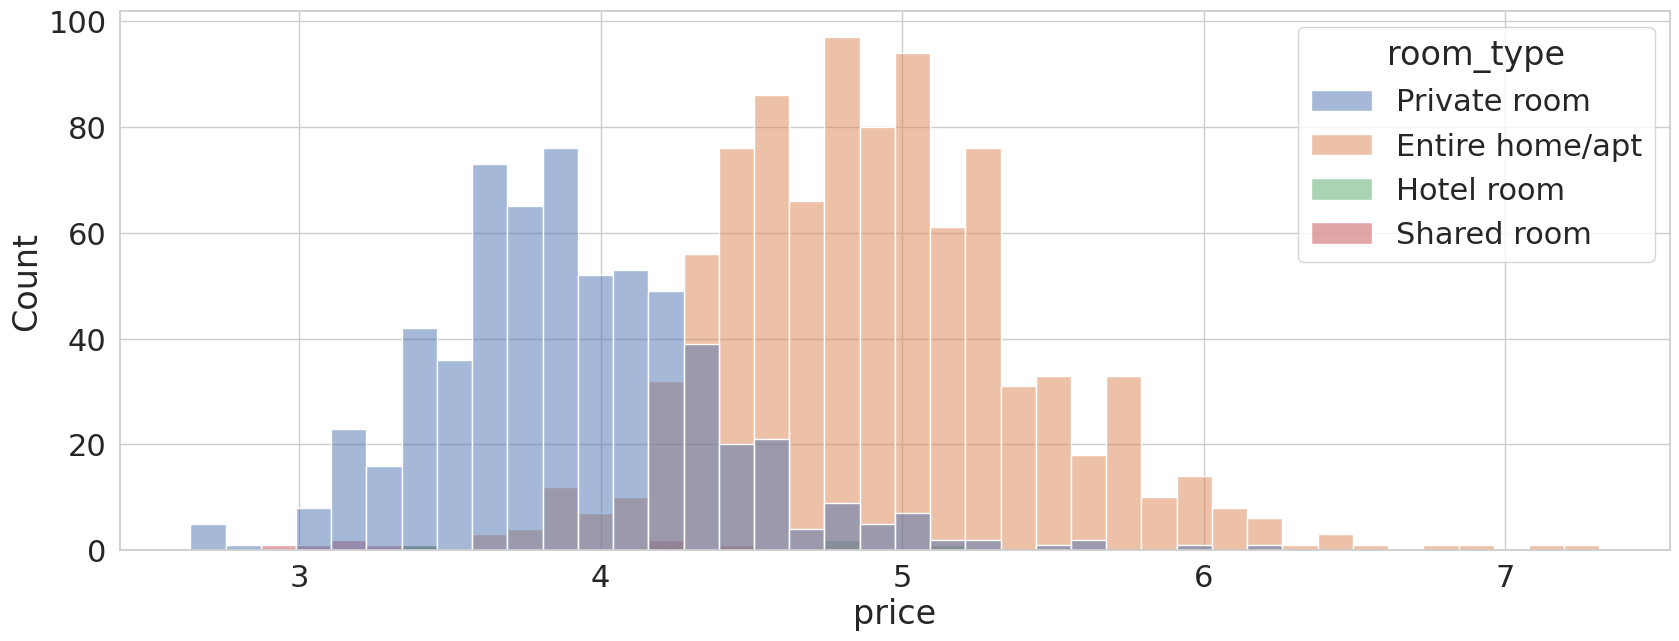

In [146]:
q = '''
    SELECT 
        room_type,
        toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) AS price 
    FROM ldn_listings
    WHERE experiences_offered != 'none'
    '''

q_test = ph.read_clickhouse(query=q, connection=ch_conn)
print(sns.histplot(data=q_test, x='price', stat='count', hue='room_type', bins=40))
plt.show()
print(sns.histplot(data=q_test, x=np.log(q_test.price), stat='count', hue='room_type', bins=40))
plt.show()
# answer - 3,5,2,6??

## Task 7 

<AxesSubplot: xlabel='year', ylabel='avg_price'>

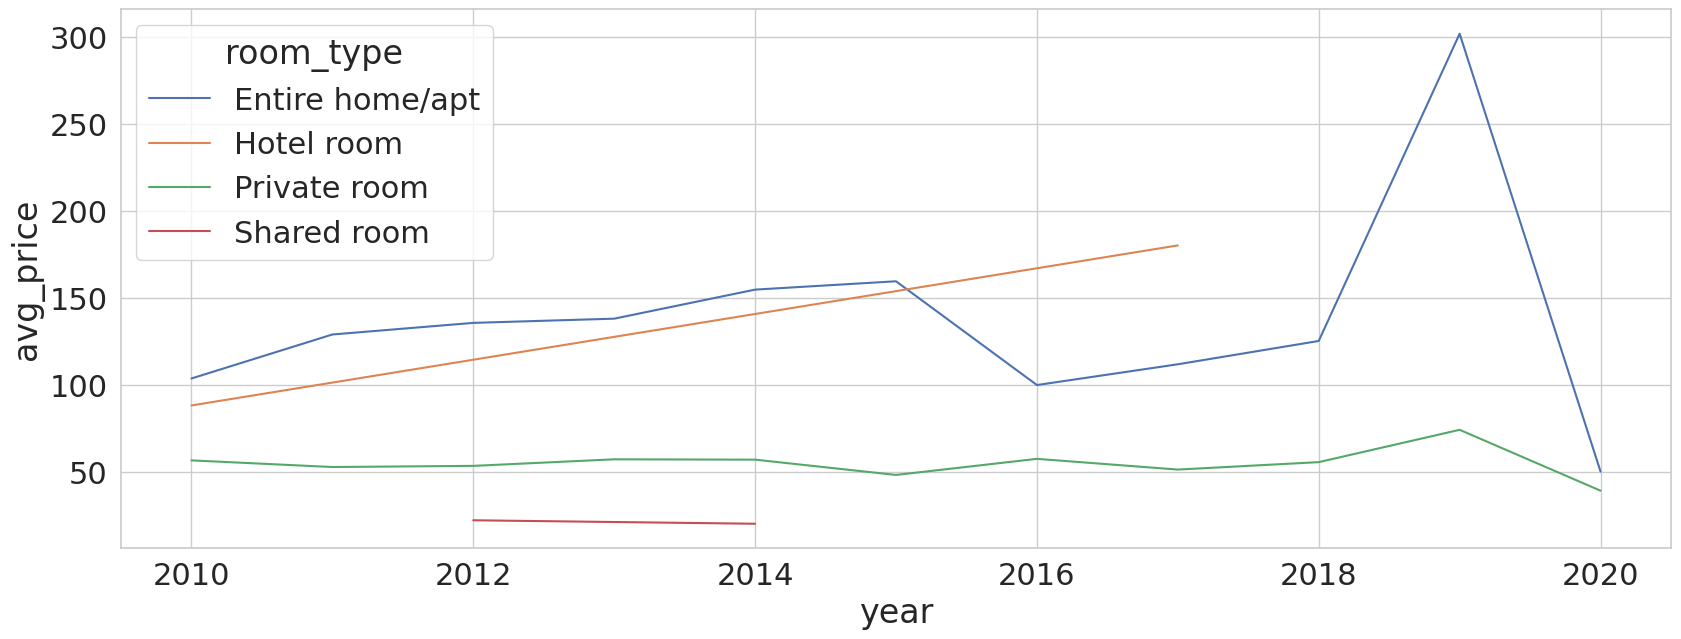

In [188]:
q = '''
    SELECT 
        room_type,
        toFloat32OrNull(replaceRegexpAll(price, '[$,]', '')) AS price,
        toYear(toDate(first_review)) as year
    FROM ldn_listings
    WHERE first_review > '2010-01-01'
    LIMIT 1000
    '''

q_test = ph.read_clickhouse(query=q, connection=ch_conn)
q_avg_price_per_year = (
    
    q_test
    .groupby(['year', 'room_type'])
    .agg(avg_price = ('price', 'mean'))
    .reset_index()

)

sns.lineplot(data=q_avg_price_per_year, x='year', y='avg_price', hue='room_type')

# answer - 1 (first graph)